In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from importlib import reload
import PIVutils

In [2]:
#PIVutils = reload(PIVutils)
X, Y, Swirl, Cond, Prof = PIVutils.importMatlabPIVdata2D('/Users/Owen/Dropbox/Data/ABL/SBL PIV data/RNV45-RI2.mat',['X','Y','Swirl'],['Cond','Prof'])

In [3]:
NanLocs = np.isnan(Swirl)
uSize = Swirl.shape
scale = (X[1,-1]-X[1,1])/(uSize[1]-1)

# Normalize field by std

In [10]:
SwirlStd = np.std(np.nanmean(Swirl,axis=2),axis = 1)

In [11]:
#Normalize field by the std of Swirl
SwirlNorm = Swirl/SwirlStd.reshape(uSize[0],1,1) #match the SwirlStd length (123) with the correct index in Swirl (also 123)

# Create thresholded field

In [12]:
import copy

SwirlFilt = copy.copy(Swirl)    #think this should completely copy the list, allowing me to try things

#Swirl must be above a certain background value or it is zeroed
SwirlFilt[np.absolute(SwirlFilt)<7] = 0

#Then only keep those locations where swirls is greater than Thresh*SwirlStd
ThreshSTD = 60
SwirlFilt[np.absolute(SwirlNorm)<ThreshSTD] = 0

# Find all blobs and filter for size


In [13]:
PIVutils = reload(PIVutils)
Thresh = 50
[num_features,features_per_frame, labeled_array, cent] = PIVutils.findBlobs(SwirlFilt,50)

There are  55342  features identified
A total of  2638  are larger than the threshold size


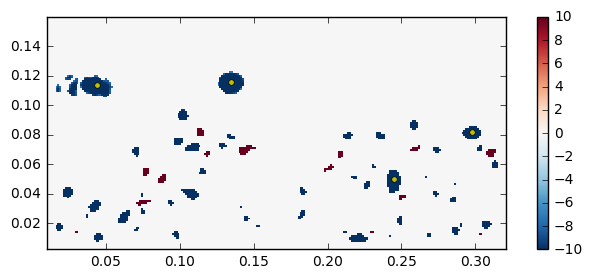

In [14]:
[f, ax] = PIVutils.plotScalarField(X,Y,SwirlFilt[:,:,1],10)

for i in range(features_per_frame[1]):
    plt.plot(cent[1][i][1]*scale+X[1,1],cent[1][i][0]*scale+Y[1,1],'oy',markersize=4,markeredgecolor=None)

# Subtract mean profile or mean at centroid of swirl blob

# Find all thumbnails

In [ ]:
BoxSize = 20

Ut, Vt = getThumbnails(U,V,cent,BoxSize)